# Preproject routine 

In [1]:
import numpy as np
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
sys.path.insert(1, module_path + '/src')

import utility

sys.path.insert(1, module_path + '/src/models/')
import helper


import librosa
import sktime
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sklearn.model_selection import train_test_split

from math import ceil

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
from scipy.stats import skew 


sys.path.insert(1, '/home/andrine/Desktop/tqwt_tools')
from tqwt_tools import DualQDecomposition
from scipy.signal import butter, lfilter
from scipy.fft import fft
from scipy.signal import stft
from scipy.stats import skew, kurtosis
from PyEMD import EEMD
from sklearn.cross_decomposition import PLSRegression

from time import time
import sys
import os
figure_path = module_path + '/figures/small_segment_dataset_plots/'

sys.path.insert(1, module_path + '/src/')

from matplotlib.font_manager import FontProperties
font = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 10, weight = 1000)
font_small = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 8, weight = 1000)
colors = ['#F94144', '#90BE6D', '#577590','#F3722C', '#F8961E', '#F9844A', '#F9C74F', '#43AA8B', '#4D908E', '#277DA1']
colors_opa = ['#F9414466', '#90BE6D66', '#57759066','#F3722C66', '#F8961E66',
              '#F9844A66', '#F9C74F66', '#43AA8B66', '#4D908E66', '#277DA166']

sns.set_palette(sns.color_palette(colors))



def znorm(timeseries):
    mean = np.mean(timeseries)
    sd = np.std(timeseries)
    return (timeseries - mean)/sd

target_rate = 44100
ds_target_rate = 8000

import os
names = []
#files_path = '/home/andrine/Desktop/dataTromso/Hasse413/'
#files_path = '/home/andrine/Desktop/dataTromsoFiltered/allFilteres/'

files_path = module_path + '/data/minimal_dataset/data/'
info = pd.read_csv(module_path + '/data/minimal_dataset/info.csv')

Defining some helping functions, that will be important when extracting 

In [8]:
def get_features(data, sr):
    sr = sr
    n_mfcc = 30
    ft1 = librosa.feature.mfcc(data, sr = sr, n_mfcc=n_mfcc)
    ft2 = librosa.feature.zero_crossing_rate(data)[0]
    ft3 = librosa.feature.spectral_rolloff(data)[0]
    ft4 = librosa.feature.spectral_centroid(data)[0]
    ft5 = librosa.feature.spectral_contrast(data)[0]
    ft6 = librosa.feature.spectral_bandwidth(data)[0]

    ### Get HOS and simple features 
    ft0_trunc = np.hstack((np.mean(data) , np.std(data), skew(data), np.max(data), np.median(data), np.min(data), utility.get_energy(data), utility.get_entropy(data)))

    ### MFCC features
    ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))

    ### Spectral Features 
    ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
    ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
    ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
    ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)))
    ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.median(ft6), np.max(ft6)))
    return np.hstack((ft0_trunc , ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc))


def get_xf(audio, sr):
    duration = float(len(audio)) / sr
    T = 1.0/sr
    N = int(duration / T)
    x = np.linspace(0.0, N*T, N +1 )
    if len(x) != len(audio):
        x = np.linspace(0.0, N*T, N)
    return x

def get_emd_features(audio, sr, n_imfs):
    m_imf = n_imfs
    m_sift = 30
    m_trials = 5

    eemd = EEMD(trials=m_trials)
    eemd.spline_kind="slinear"
    eemd.FIXE = m_sift
    
    x = get_xf(audio, sr)

    eIMFs = eemd.eemd(audio, x, max_imf = m_imf)
    
    features = []
    for imf in eIMFs:
        features.append(get_features(imf, sr))
    return np.hstack(features)

Obtaining the data correlated with filepath, label and ID

Cutting the dataset down to 3 classes, and balancing the dataset

In [3]:
info['label'].value_counts()

wheeze     704
crackle    582
normal     554
Name: label, dtype: int64

In [9]:
indices = np.concatenate([np.where(info['label'] == 'normal')[0],
                          np.where(info['label'] == 'wheeze')[0][:580],
                          np.where(info['label'] == 'crackle')[0]])

'''indices = np.concatenate([np.where(info['label'] == 'wheeze')[0][:580],
                          np.where(info['label'] == 'crackle')[0]])'''


info = info.iloc[indices]

### Making unbiased train, test, val splits 

In [10]:
from sklearn.model_selection import train_test_split

info.sort_values(by=['patient_id'], inplace=True)


id_unique = info['patient_id'].unique()

id_train , id_test = train_test_split(id_unique, test_size=0.2, random_state=42)
id_train , id_val = train_test_split(id_unique, test_size=0.25, random_state=42)

def get_indices(id_list, data):
    indices = np.array([])
    for i in id_list:
        idx = np.where(data['patient_id'] == i)[0]
        indices = np.append([list(idx)] , [indices])
        
    return indices


indices_train = get_indices(id_train, info).astype(int)
indices_test = get_indices(id_test, info).astype(int)
indices_val = get_indices(id_val, info).astype(int)

print(info.iloc[indices_train]['label'].value_counts())

crackle    438
wheeze     431
normal     418
Name: label, dtype: int64


In [11]:
def get_data_array(data):
    error_in_data = {}
    count = 0
    
    X = []
    y = []
    for row in data.iterrows():
        audio_file = row[1]['filepath_new']
        label = row[1]['label']

        try:
            sr, audio = utility.read_wav_file(audio_file, 8000)

        except EOFError as error:
            error_in_data[audio_file] = 'EOFError'
            continue

        try:
            #audio = znorm(audio)
            #features = get_features(audio, sr)
            features = get_emd_features(audio, sr, 5)
            if len(features)!= 1308:
                print('Not long enough')
                continue
            X.append(features)
            y.append(label)
            
            count = count + 1
            print(f'Features extracted from : {count} of {len(data)}')

        except ValueError as error:
            error_in_data[audio_file] = 'ValueError'
            continue
    return (np.array(X), pd.Series(y))


indices = {
    'train' : indices_train,
    'test' : indices_test,
    'val' : indices_val
    
}

result_datasets = {
    'train' : ([], []),
    'test' : ([], []),
    'val' : ([], [])
    
}


start = time()
for name, i in indices.items():
    result_datasets[name] = get_data_array(info.iloc[i])

X_train, y_train = result_datasets['train']
X_test, y_test = result_datasets['test']
X_val, y_val = result_datasets['val']

print(f'Time: {time() - start}')

Features extracted from : 1 of 1287
Features extracted from : 2 of 1287
Features extracted from : 3 of 1287
Features extracted from : 4 of 1287
Features extracted from : 5 of 1287
Features extracted from : 6 of 1287
Features extracted from : 7 of 1287
Features extracted from : 8 of 1287
Features extracted from : 9 of 1287
Features extracted from : 10 of 1287
Features extracted from : 11 of 1287
Features extracted from : 12 of 1287
Features extracted from : 13 of 1287
Features extracted from : 14 of 1287
Features extracted from : 15 of 1287
Features extracted from : 16 of 1287
Features extracted from : 17 of 1287
Features extracted from : 18 of 1287
Features extracted from : 19 of 1287
Features extracted from : 20 of 1287
Features extracted from : 21 of 1287
Features extracted from : 22 of 1287
Features extracted from : 23 of 1287
Features extracted from : 24 of 1287
Features extracted from : 25 of 1287
Features extracted from : 26 of 1287
Features extracted from : 27 of 1287
Features e

Features extracted from : 220 of 1287
Features extracted from : 221 of 1287
Features extracted from : 222 of 1287
Features extracted from : 223 of 1287
Features extracted from : 224 of 1287
Features extracted from : 225 of 1287
Features extracted from : 226 of 1287
Features extracted from : 227 of 1287
Features extracted from : 228 of 1287
Features extracted from : 229 of 1287
Features extracted from : 230 of 1287
Features extracted from : 231 of 1287
Features extracted from : 232 of 1287
Features extracted from : 233 of 1287
Features extracted from : 234 of 1287
Features extracted from : 235 of 1287
Features extracted from : 236 of 1287
Features extracted from : 237 of 1287
Features extracted from : 238 of 1287
Features extracted from : 239 of 1287
Features extracted from : 240 of 1287
Features extracted from : 241 of 1287
Features extracted from : 242 of 1287
Features extracted from : 243 of 1287
Features extracted from : 244 of 1287
Features extracted from : 245 of 1287
Features ext

Features extracted from : 436 of 1287
Features extracted from : 437 of 1287
Features extracted from : 438 of 1287
Features extracted from : 439 of 1287
Features extracted from : 440 of 1287
Features extracted from : 441 of 1287
Features extracted from : 442 of 1287
Features extracted from : 443 of 1287
Features extracted from : 444 of 1287
Features extracted from : 445 of 1287
Features extracted from : 446 of 1287
Features extracted from : 447 of 1287
Features extracted from : 448 of 1287
Features extracted from : 449 of 1287
Features extracted from : 450 of 1287
Features extracted from : 451 of 1287
Features extracted from : 452 of 1287
Features extracted from : 453 of 1287
Features extracted from : 454 of 1287
Features extracted from : 455 of 1287
Features extracted from : 456 of 1287
Features extracted from : 457 of 1287
Features extracted from : 458 of 1287
Features extracted from : 459 of 1287
Features extracted from : 460 of 1287
Features extracted from : 461 of 1287
Features ext

Features extracted from : 652 of 1287
Features extracted from : 653 of 1287
Features extracted from : 654 of 1287
Features extracted from : 655 of 1287
Features extracted from : 656 of 1287
Features extracted from : 657 of 1287
Features extracted from : 658 of 1287
Features extracted from : 659 of 1287
Features extracted from : 660 of 1287
Features extracted from : 661 of 1287
Features extracted from : 662 of 1287
Features extracted from : 663 of 1287
Features extracted from : 664 of 1287
Features extracted from : 665 of 1287
Features extracted from : 666 of 1287
Features extracted from : 667 of 1287
Features extracted from : 668 of 1287
Features extracted from : 669 of 1287
Features extracted from : 670 of 1287
Features extracted from : 671 of 1287
Features extracted from : 672 of 1287
Features extracted from : 673 of 1287
Features extracted from : 674 of 1287
Features extracted from : 675 of 1287
Features extracted from : 676 of 1287
Features extracted from : 677 of 1287
Features ext

Features extracted from : 868 of 1287
Features extracted from : 869 of 1287
Features extracted from : 870 of 1287
Features extracted from : 871 of 1287
Features extracted from : 872 of 1287
Features extracted from : 873 of 1287
Features extracted from : 874 of 1287
Features extracted from : 875 of 1287
Features extracted from : 876 of 1287
Features extracted from : 877 of 1287
Features extracted from : 878 of 1287
Features extracted from : 879 of 1287
Features extracted from : 880 of 1287
Features extracted from : 881 of 1287
Features extracted from : 882 of 1287
Features extracted from : 883 of 1287
Features extracted from : 884 of 1287
Features extracted from : 885 of 1287
Features extracted from : 886 of 1287
Features extracted from : 887 of 1287
Features extracted from : 888 of 1287
Features extracted from : 889 of 1287
Features extracted from : 890 of 1287
Features extracted from : 891 of 1287
Features extracted from : 892 of 1287
Features extracted from : 893 of 1287
Features ext

Features extracted from : 1082 of 1287
Features extracted from : 1083 of 1287
Features extracted from : 1084 of 1287
Features extracted from : 1085 of 1287
Features extracted from : 1086 of 1287
Features extracted from : 1087 of 1287
Features extracted from : 1088 of 1287
Features extracted from : 1089 of 1287
Features extracted from : 1090 of 1287
Features extracted from : 1091 of 1287
Features extracted from : 1092 of 1287
Features extracted from : 1093 of 1287
Features extracted from : 1094 of 1287
Features extracted from : 1095 of 1287
Features extracted from : 1096 of 1287
Features extracted from : 1097 of 1287
Features extracted from : 1098 of 1287
Features extracted from : 1099 of 1287
Features extracted from : 1100 of 1287
Features extracted from : 1101 of 1287
Features extracted from : 1102 of 1287
Features extracted from : 1103 of 1287
Features extracted from : 1104 of 1287
Features extracted from : 1105 of 1287
Features extracted from : 1106 of 1287
Features extracted from :

Features extracted from : 6 of 344
Features extracted from : 7 of 344
Features extracted from : 8 of 344
Features extracted from : 9 of 344
Features extracted from : 10 of 344
Features extracted from : 11 of 344
Features extracted from : 12 of 344
Features extracted from : 13 of 344
Features extracted from : 14 of 344
Features extracted from : 15 of 344
Features extracted from : 16 of 344
Features extracted from : 17 of 344
Features extracted from : 18 of 344
Features extracted from : 19 of 344
Features extracted from : 20 of 344
Features extracted from : 21 of 344
Features extracted from : 22 of 344
Features extracted from : 23 of 344
Features extracted from : 24 of 344
Features extracted from : 25 of 344
Features extracted from : 26 of 344
Features extracted from : 27 of 344
Features extracted from : 28 of 344
Features extracted from : 29 of 344
Features extracted from : 30 of 344
Features extracted from : 31 of 344
Features extracted from : 32 of 344
Features extracted from : 33 of 

Features extracted from : 231 of 344
Features extracted from : 232 of 344
Features extracted from : 233 of 344
Features extracted from : 234 of 344
Features extracted from : 235 of 344
Features extracted from : 236 of 344
Features extracted from : 237 of 344
Features extracted from : 238 of 344
Features extracted from : 239 of 344
Features extracted from : 240 of 344
Features extracted from : 241 of 344
Features extracted from : 242 of 344
Features extracted from : 243 of 344
Features extracted from : 244 of 344
Features extracted from : 245 of 344
Features extracted from : 246 of 344
Features extracted from : 247 of 344
Features extracted from : 248 of 344
Features extracted from : 249 of 344
Features extracted from : 250 of 344
Features extracted from : 251 of 344
Features extracted from : 252 of 344
Features extracted from : 253 of 344
Features extracted from : 254 of 344
Features extracted from : 255 of 344
Features extracted from : 256 of 344
Features extracted from : 257 of 344
F

Features extracted from : 112 of 429
Features extracted from : 113 of 429
Features extracted from : 114 of 429
Features extracted from : 115 of 429
Features extracted from : 116 of 429
Features extracted from : 117 of 429
Features extracted from : 118 of 429
Features extracted from : 119 of 429
Features extracted from : 120 of 429
Features extracted from : 121 of 429
Features extracted from : 122 of 429
Features extracted from : 123 of 429
Features extracted from : 124 of 429
Features extracted from : 125 of 429
Features extracted from : 126 of 429
Features extracted from : 127 of 429
Features extracted from : 128 of 429
Features extracted from : 129 of 429
Features extracted from : 130 of 429
Features extracted from : 131 of 429
Features extracted from : 132 of 429
Features extracted from : 133 of 429
Features extracted from : 134 of 429
Features extracted from : 135 of 429
Features extracted from : 136 of 429
Features extracted from : 137 of 429
Features extracted from : 138 of 429
F

Features extracted from : 334 of 429
Features extracted from : 335 of 429
Features extracted from : 336 of 429
Features extracted from : 337 of 429
Features extracted from : 338 of 429
Features extracted from : 339 of 429
Features extracted from : 340 of 429
Features extracted from : 341 of 429
Features extracted from : 342 of 429
Features extracted from : 343 of 429
Features extracted from : 344 of 429
Features extracted from : 345 of 429
Features extracted from : 346 of 429
Features extracted from : 347 of 429
Features extracted from : 348 of 429
Features extracted from : 349 of 429
Features extracted from : 350 of 429
Features extracted from : 351 of 429
Features extracted from : 352 of 429
Features extracted from : 353 of 429
Features extracted from : 354 of 429
Features extracted from : 355 of 429
Features extracted from : 356 of 429
Features extracted from : 357 of 429
Features extracted from : 358 of 429
Features extracted from : 359 of 429
Features extracted from : 360 of 429
F

In [10]:
file_splits = {
    '/features/extracted_ts_files/minimal_dataset_2class__preprojectEEMD_TRAIN.ts' : (X_train, y_train),
    '/features/extracted_ts_files/minimal_dataset_2class__preprojectEEMD_TEST.ts' : (X_test, y_test),
    '/features/extracted_ts_files/minimal_dataset_2class__preprojectEEMD_VAL.ts' : (X_val, y_val)
}


def write_feature_extracted_dataset_to_ts(filename, X,y):

    w = open(module_path + filename, 'w+')
    row = w.read()

    w.write('@problemName Minimal UiT Lung Sound \n')
    w.write('@timeStamps false \n')
    w.write('@missing false \n')
    w.write('@univariate true \n')
    w.write('@equalLength true \n')
    w.write('@classLabel true crackle wheeze \n')
    w.write('@data \n')

    error_in_data = {}
    count = 0
    for idx, row in enumerate(X):
        label = y[idx]

        try:
            new_row = str(list(row))[1:-1].replace(' ', '') + ':' + label + '\n'
            w.write(new_row)


        except ValueError as error:
            error_in_data[audio_file] = 'ValueError'
            continue
             
for name, i in file_splits.items():
    write_feature_extracted_dataset_to_ts(name, i[0], i[1])

# Testing classification 

## Preproject dataset, with EEMD 

In [2]:
from sktime.utils.data_processing import from_nested_to_2d_array
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn import preprocessing

X_train, y_train = load_from_tsfile_to_dataframe(module_path + '/features/extracted_ts_files/minimal_dataset_3class__preprojectEEMD_TRAIN.ts')
X_test, y_test = load_from_tsfile_to_dataframe(module_path + '/features/extracted_ts_files/minimal_dataset_3class__preprojectEEMD_TEST.ts')
X_val, y_val = load_from_tsfile_to_dataframe(module_path + '/features/extracted_ts_files/minimal_dataset_3class__preprojectEEMD_VAL.ts')


X_train = from_nested_to_2d_array(X_train)
X_test = from_nested_to_2d_array(X_test)
X_val = from_nested_to_2d_array(X_val)

              precision    recall  f1-score   support

     crackle       0.54      0.60      0.57       111
      normal       0.45      0.50      0.47       105
      wheeze       0.52      0.41      0.46       128

    accuracy                           0.50       344
   macro avg       0.50      0.51      0.50       344
weighted avg       0.51      0.50      0.50       344



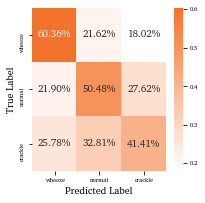

In [3]:
scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


selector = SelectKBest(mutual_info_regression, k =30)
le  = preprocessing.LabelEncoder()
le.fit(y_train)
y_train_ = le.transform(y_train)
selector.fit(X_train, y_train_)
X_train = selector.transform(X_train)
X_val = selector.transform(X_val)
X_test = selector.transform(X_test)

class_names =  list(pd.factorize(y_train)[1])
clf = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500,random_state=42)

#clf = SVC(C=100, gamma=0.1)

clf.fit(X_train , y_train)
y_pred = clf.predict(X_test)

f, ax = utility.plot_cm(y_test, y_pred, module_path = module_path, class_names = class_names, color_index = 1)

f.savefig(figure_path + f'cm_preprojectEEMD_3class_rf.pdf', bbox_inches='tight')

print(classification_report(y_test, y_pred))

In [4]:
from sktime.utils.data_processing import from_nested_to_2d_array

X_train, y_train = load_from_tsfile_to_dataframe(module_path + '/features/extracted_ts_files/minimal_dataset_2class__preprojectEEMD_TRAIN.ts')
X_test, y_test = load_from_tsfile_to_dataframe(module_path + '/features/extracted_ts_files/minimal_dataset_2class__preprojectEEMD_TEST.ts')
X_val, y_val = load_from_tsfile_to_dataframe(module_path + '/features/extracted_ts_files/minimal_dataset_2class__preprojectEEMD_VAL.ts')


X_train = from_nested_to_2d_array(X_train)
X_test = from_nested_to_2d_array(X_test)
X_val = from_nested_to_2d_array(X_val)

              precision    recall  f1-score   support

     crackle       0.76      0.73      0.74       123
      wheeze       0.72      0.75      0.73       114

    accuracy                           0.74       237
   macro avg       0.74      0.74      0.74       237
weighted avg       0.74      0.74      0.74       237



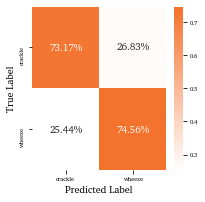

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


selector = SelectKBest(mutual_info_regression, k =30)
le  = preprocessing.LabelEncoder()
le.fit(y_train)
y_train_ = le.transform(y_train)
selector.fit(X_train, y_train_)
X_train = selector.transform(X_train)
X_val = selector.transform(X_val)
X_test = selector.transform(X_test)

class_names =  list(pd.factorize(y_train)[1])
clf = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500,random_state=42)

#clf = SVC(C=100, gamma=0.1)

clf.fit(X_train , y_train)
y_pred = clf.predict(X_test)

f, ax = utility.plot_cm(y_test, y_pred, module_path = module_path, class_names = class_names, color_index = 1)

f.savefig(figure_path + f'cm_preprojectEEMD_2class_rf.pdf', bbox_inches='tight')

print(classification_report(y_test, y_pred))

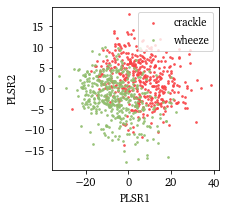

In [9]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train_ = le.transform(y_train)

pls2 = PLSRegression(n_components=2)
p2 = pls2.fit_transform(X_train, y_train_)
f, ax = helper.scatterplot_with_colors(p2[0], y_train_,
                                       module_path, new_legends = le.classes_,
                                       x_y_labels = ['PLSR1', 'PLSR2'])

plt.show()

f.savefig(figure_path + f'PLSR_preprojectEEMD_2class.pdf', bbox_inches='tight')

## Preproject , without EEMD

In [26]:
from sktime.utils.data_processing import from_nested_to_2d_array

X_train, y_train = load_from_tsfile_to_dataframe(module_path + '/features/extracted_ts_files/minimal_dataset_3class__preproject_TRAIN.ts')
X_test, y_test = load_from_tsfile_to_dataframe(module_path + '/features/extracted_ts_files/minimal_dataset_3class__preproject_TEST.ts')
X_val, y_val = load_from_tsfile_to_dataframe(module_path + '/features/extracted_ts_files/minimal_dataset_3class__preproject_VAL.ts')


X_train = from_nested_to_2d_array(X_train)
X_test = from_nested_to_2d_array(X_test)
X_val = from_nested_to_2d_array(X_val)

              precision    recall  f1-score   support

     crackle       0.56      0.65      0.60       111
      normal       0.52      0.41      0.46       105
      wheeze       0.62      0.64      0.63       128

    accuracy                           0.57       344
   macro avg       0.57      0.57      0.56       344
weighted avg       0.57      0.57      0.57       344



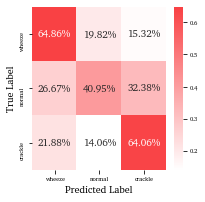

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

class_names =  list(pd.factorize(y_train)[1])
clf = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500,random_state=42)

#clf = SVC(C=100, gamma=0.1)

clf.fit(X_train , y_train)
y_pred = clf.predict(X_test)

f, ax = utility.plot_cm(y_test, y_pred, module_path = module_path, class_names = class_names, color_index = 0)

f.savefig(figure_path + f'cm_preproject_3class_rf.pdf', bbox_inches='tight')

print(classification_report(y_test, y_pred))

In [28]:
from sktime.utils.data_processing import from_nested_to_2d_array

X_train, y_train = load_from_tsfile_to_dataframe(module_path + '/features/extracted_ts_files/minimal_dataset_2class__preproject_TRAIN.ts')
X_test, y_test = load_from_tsfile_to_dataframe(module_path + '/features/extracted_ts_files/minimal_dataset_2class__preproject_TEST.ts')
X_val, y_val = load_from_tsfile_to_dataframe(module_path + '/features/extracted_ts_files/minimal_dataset_2class__preproject_VAL.ts')


X_train = from_nested_to_2d_array(X_train)
X_test = from_nested_to_2d_array(X_test)
X_val = from_nested_to_2d_array(X_val)

              precision    recall  f1-score   support

     crackle       0.82      0.84      0.83       123
      wheeze       0.82      0.80      0.81       114

    accuracy                           0.82       237
   macro avg       0.82      0.82      0.82       237
weighted avg       0.82      0.82      0.82       237



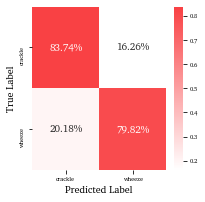

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

class_names =  list(pd.factorize(y_train)[1])
clf = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500,random_state=42)

#clf = SVC(C=100, gamma=0.1)

clf.fit(X_train , y_train)
y_pred = clf.predict(X_test)

f, ax = utility.plot_cm(y_test, y_pred, module_path = module_path, class_names = class_names, color_index = 0)

f.savefig(figure_path + f'cm_preproject_2class_rf.pdf', bbox_inches='tight')

print(classification_report(y_test, y_pred))

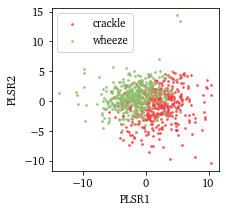

In [30]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train_ = le.transform(y_train)

pls2 = PLSRegression(n_components=2)
p2 = pls2.fit_transform(X_train, y_train_)
f, ax = helper.scatterplot_with_colors(p2[0], y_train_,
                                       module_path, new_legends = le.classes_,
                                       x_y_labels = ['PLSR1', 'PLSR2'])

plt.show()

f.savefig(figure_path + f'PLSR_preproject_2class.pdf', bbox_inches='tight')